## Pre and Post Data CLeaning EDA

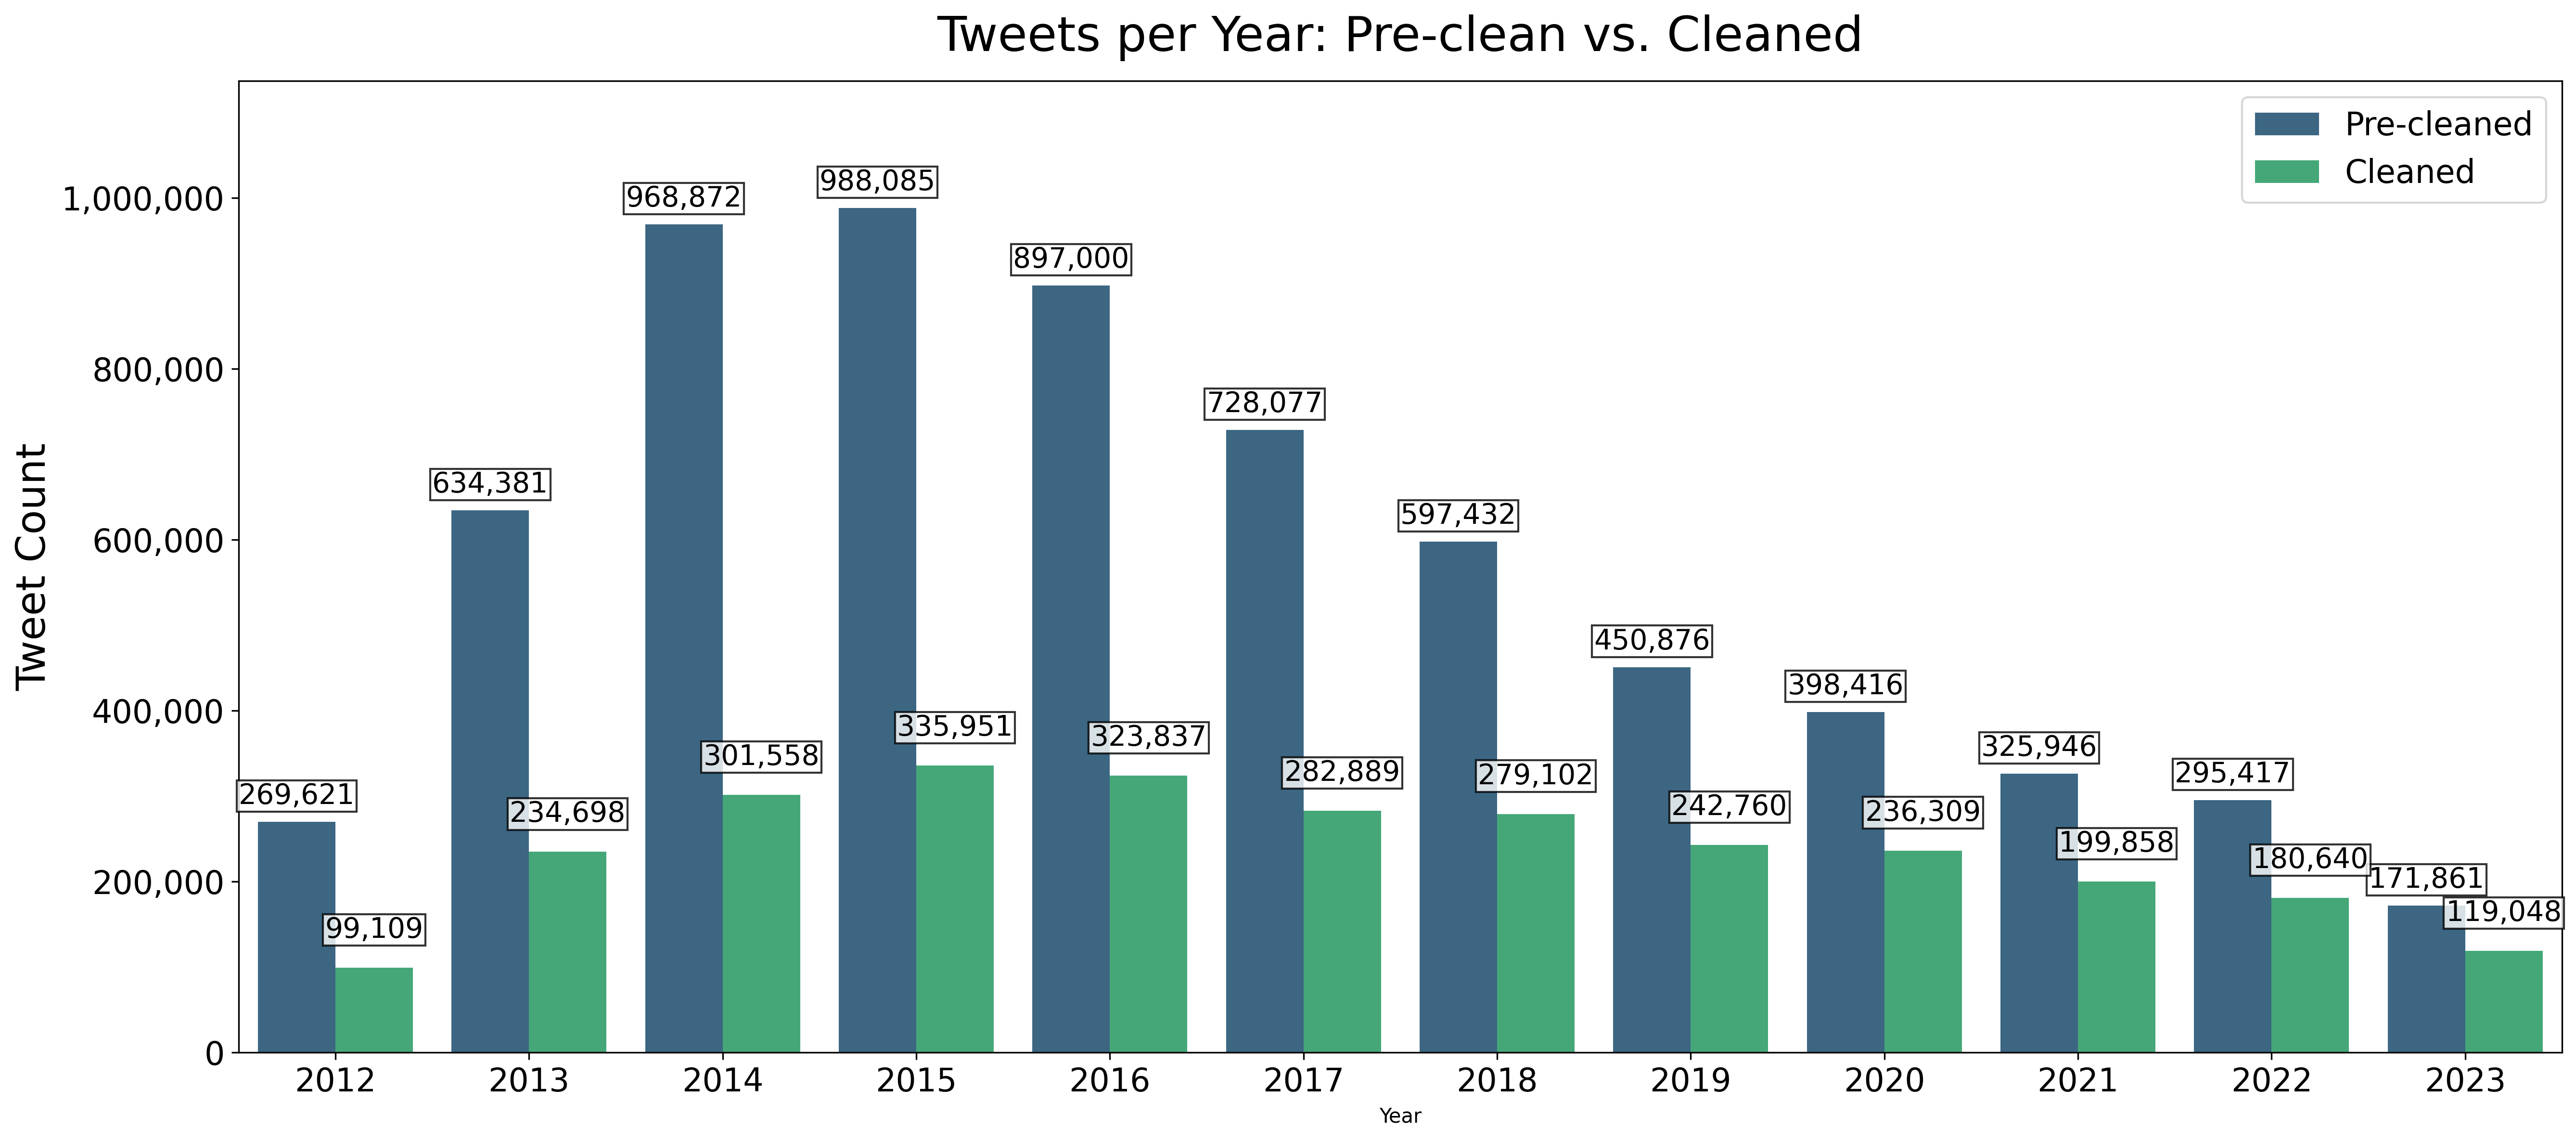

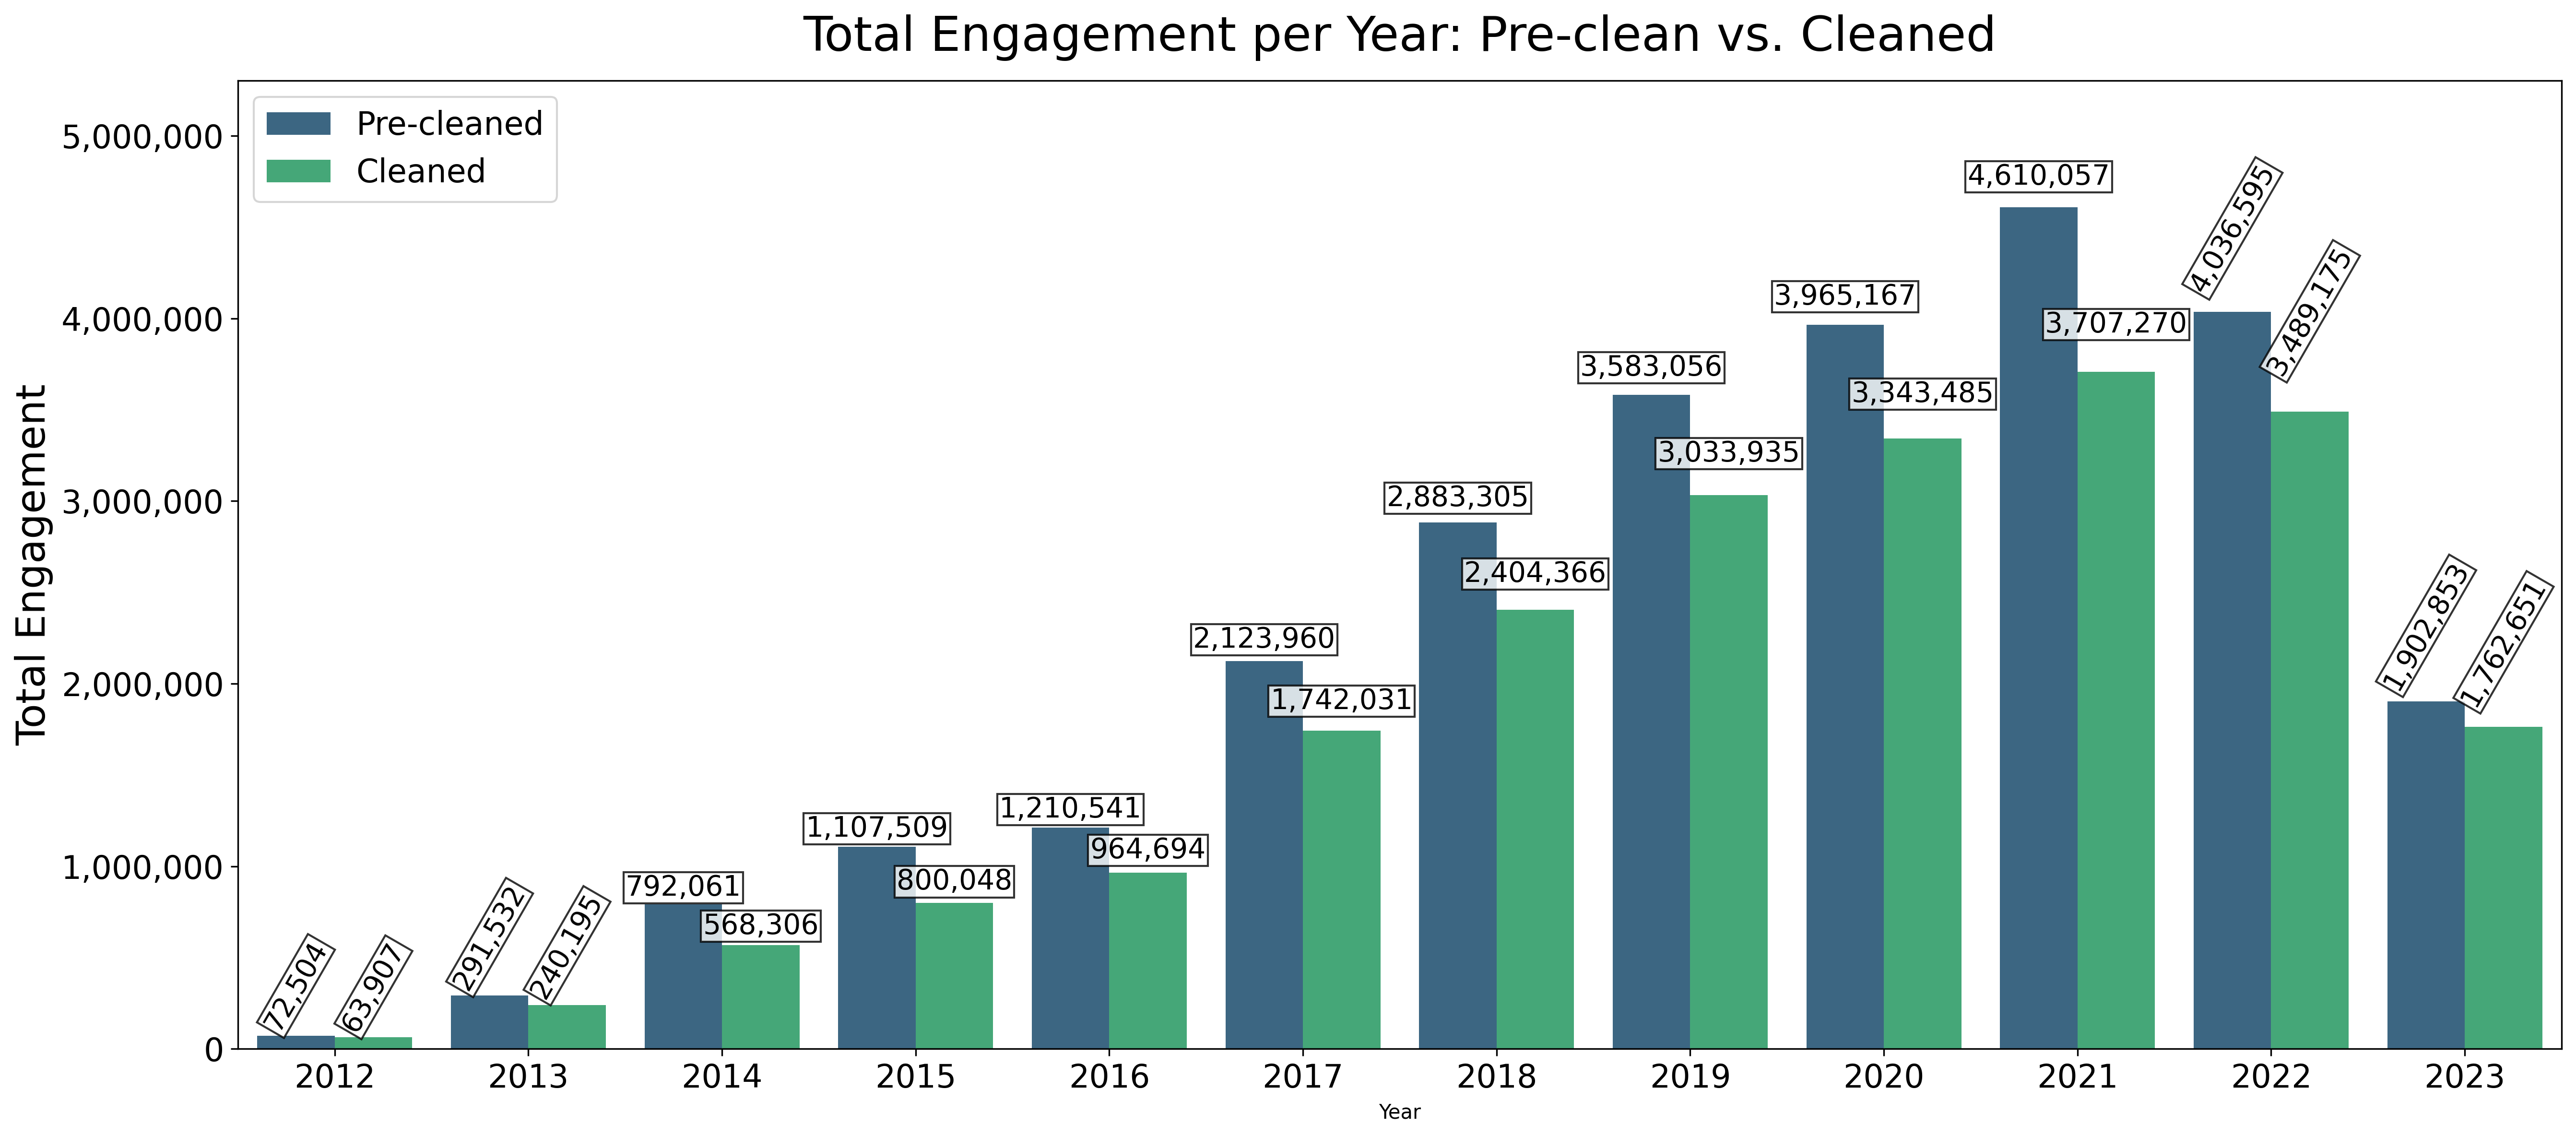

In [2]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import numpy as np
from scipy.stats import pearsonr
plt.rcParams["axes.titlepad"] = 15   # move titles upward

# --- 1) LOAD & PROCESS PRE-CLEANED DATASET ---
all_csv_files = glob.glob("/home/shola/research_raw_data/**/*.csv", recursive=True)
df_raw = pd.concat((pd.read_csv(f) for f in all_csv_files), ignore_index=True)

df_raw = df_raw.drop(columns="Views", errors="ignore")
df_raw["Total Engagement"] = df_raw[["Replies", "Likes", "Reshares"]].sum(axis=1)
df_raw["Date"] = pd.to_datetime(df_raw["Date"], format="ISO8601")
df_raw = df_raw[~df_raw["Date"].dt.year.isin([2011, 2024, 2025])]

raw_counts = (
    df_raw
    .groupby(df_raw["Date"].dt.year)
    .size()
    .reset_index(name="Tweet Count")
    .rename(columns={"Date": "Year"})
)
raw_eng = (
    df_raw
    .groupby(df_raw["Date"].dt.year)["Total Engagement"]
    .sum()
    .reset_index()
    .rename(columns={"Date": "Year"})
)
raw_counts["Dataset"] = raw_eng["Dataset"] = "Pre-cleaned"


# --- 2) LOAD & PROCESS CLEANED DATASET ---
df_clean = pd.read_csv("CLEANED_DATASET_20250531_004116.csv")
df_clean = df_clean.drop(columns="Views", errors="ignore")
df_clean["Date"] = pd.to_datetime(df_clean["Date"], format="ISO8601")
df_clean = df_clean[~df_clean["Date"].dt.year.isin([2011, 2024, 2025])]

clean_counts = (
    df_clean
    .groupby(df_clean["Date"].dt.year)
    .size()
    .reset_index(name="Tweet Count")
    .rename(columns={"Date": "Year"})
)
clean_eng = (
    df_clean
    .groupby(df_clean["Date"].dt.year)["Total Engagement"]
    .sum()
    .reset_index()
    .rename(columns={"Date": "Year"})
)
clean_counts["Dataset"] = clean_eng["Dataset"] = "Cleaned"


# --- 3) CONCATENATE & CAST YEAR TO STRING ---
counts_df = pd.concat([raw_counts, clean_counts], ignore_index=True)
eng_df    = pd.concat([raw_eng,    clean_eng],    ignore_index=True)

# Convert Year to integer then string so x-axis shows "2012", not "2012.0"
counts_df["Year"] = counts_df["Year"].astype(int).astype(str)
eng_df   ["Year"] = eng_df   ["Year"].astype(int).astype(str)


# --- 4A) PLOT TWEET COUNTS (UNCHANGED) ---
fig, ax = plt.subplots(figsize=(18, 8), dpi=300)
sns.barplot(
    data=counts_df, x="Year", y="Tweet Count", hue="Dataset",
    palette="viridis", dodge=True, ax=ax
)
ax.set_title("Tweets per Year: Pre-clean vs. Cleaned", fontsize=24)
ax.set_ylabel("Tweet Count", fontsize=20)
ax.tick_params(labelsize=16)

# Format y-axis with commas
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x):,}"))

# Add headroom so labels don’t clip
max_count = counts_df["Tweet Count"].max()
ax.set_ylim(0, max_count * 1.15)

# Label bars
pre_cont, clean_cont = ax.containers
ax.bar_label(pre_cont,
             labels=[f"{int(v):,}" for v in pre_cont.datavalues],
             padding=6, label_type='edge', fontsize=14,
             bbox=dict(facecolor="white", alpha=0.8, pad=1))
ax.bar_label(clean_cont,
             labels=[f"{int(v):,}" for v in clean_cont.datavalues],
             padding=12, label_type='edge', fontsize=14,
             bbox=dict(facecolor="white", alpha=0.8, pad=1))

ax.legend(fontsize=16)
plt.tight_layout()
plt.savefig("./visualizations/tweets_per_year.png", dpi=300, bbox_inches="tight")
plt.show()


# --- 4B) PLOT TOTAL ENGAGEMENT (ROTATE SPECIFIC YEARS) ---
fig, ax = plt.subplots(figsize=(18, 8), dpi=300)
sns.barplot(
    data=eng_df, x="Year", y="Total Engagement", hue="Dataset",
    palette="viridis", dodge=True, ax=ax
)
ax.set_title("Total Engagement per Year: Pre-clean vs. Cleaned", fontsize=24)
ax.set_ylabel("Total Engagement", fontsize=20)
ax.tick_params(labelsize=16)

# Format y-axis with commas
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x):,}"))

# Add headroom so labels don’t clip
max_eng = eng_df["Total Engagement"].max()
ax.set_ylim(0, max_eng * 1.15)

# Annotate & rotate select years
years = list(counts_df["Year"].unique())  # now strings
for i, container in enumerate(ax.containers):
    rel_pad = 0.02 if i == 0 else 0.05
    for j, rect in enumerate(container):
        h = rect.get_height()
        x_pt = rect.get_x() + rect.get_width() / 2
        y_pt = h + h * rel_pad
        year = years[j]
        rotation = 60 if year in ("2012", "2013", "2022", "2023") else 0

        ax.text(
            x_pt, y_pt,
            f"{int(h):,}",
            ha="center", va="bottom",
            rotation=rotation, fontsize=14,
            bbox=dict(facecolor="white", alpha=0.8, pad=1)
        )

ax.legend(fontsize=16)
plt.tight_layout()
plt.savefig("./visualizations/engagement_per_year.png", dpi=300, bbox_inches="tight")
plt.show()


Tweet Count correlation: Pearson r = 0.910, p = 4.07e-05
Engagement correlation: Pearson r = 0.998, p = 5.86e-13


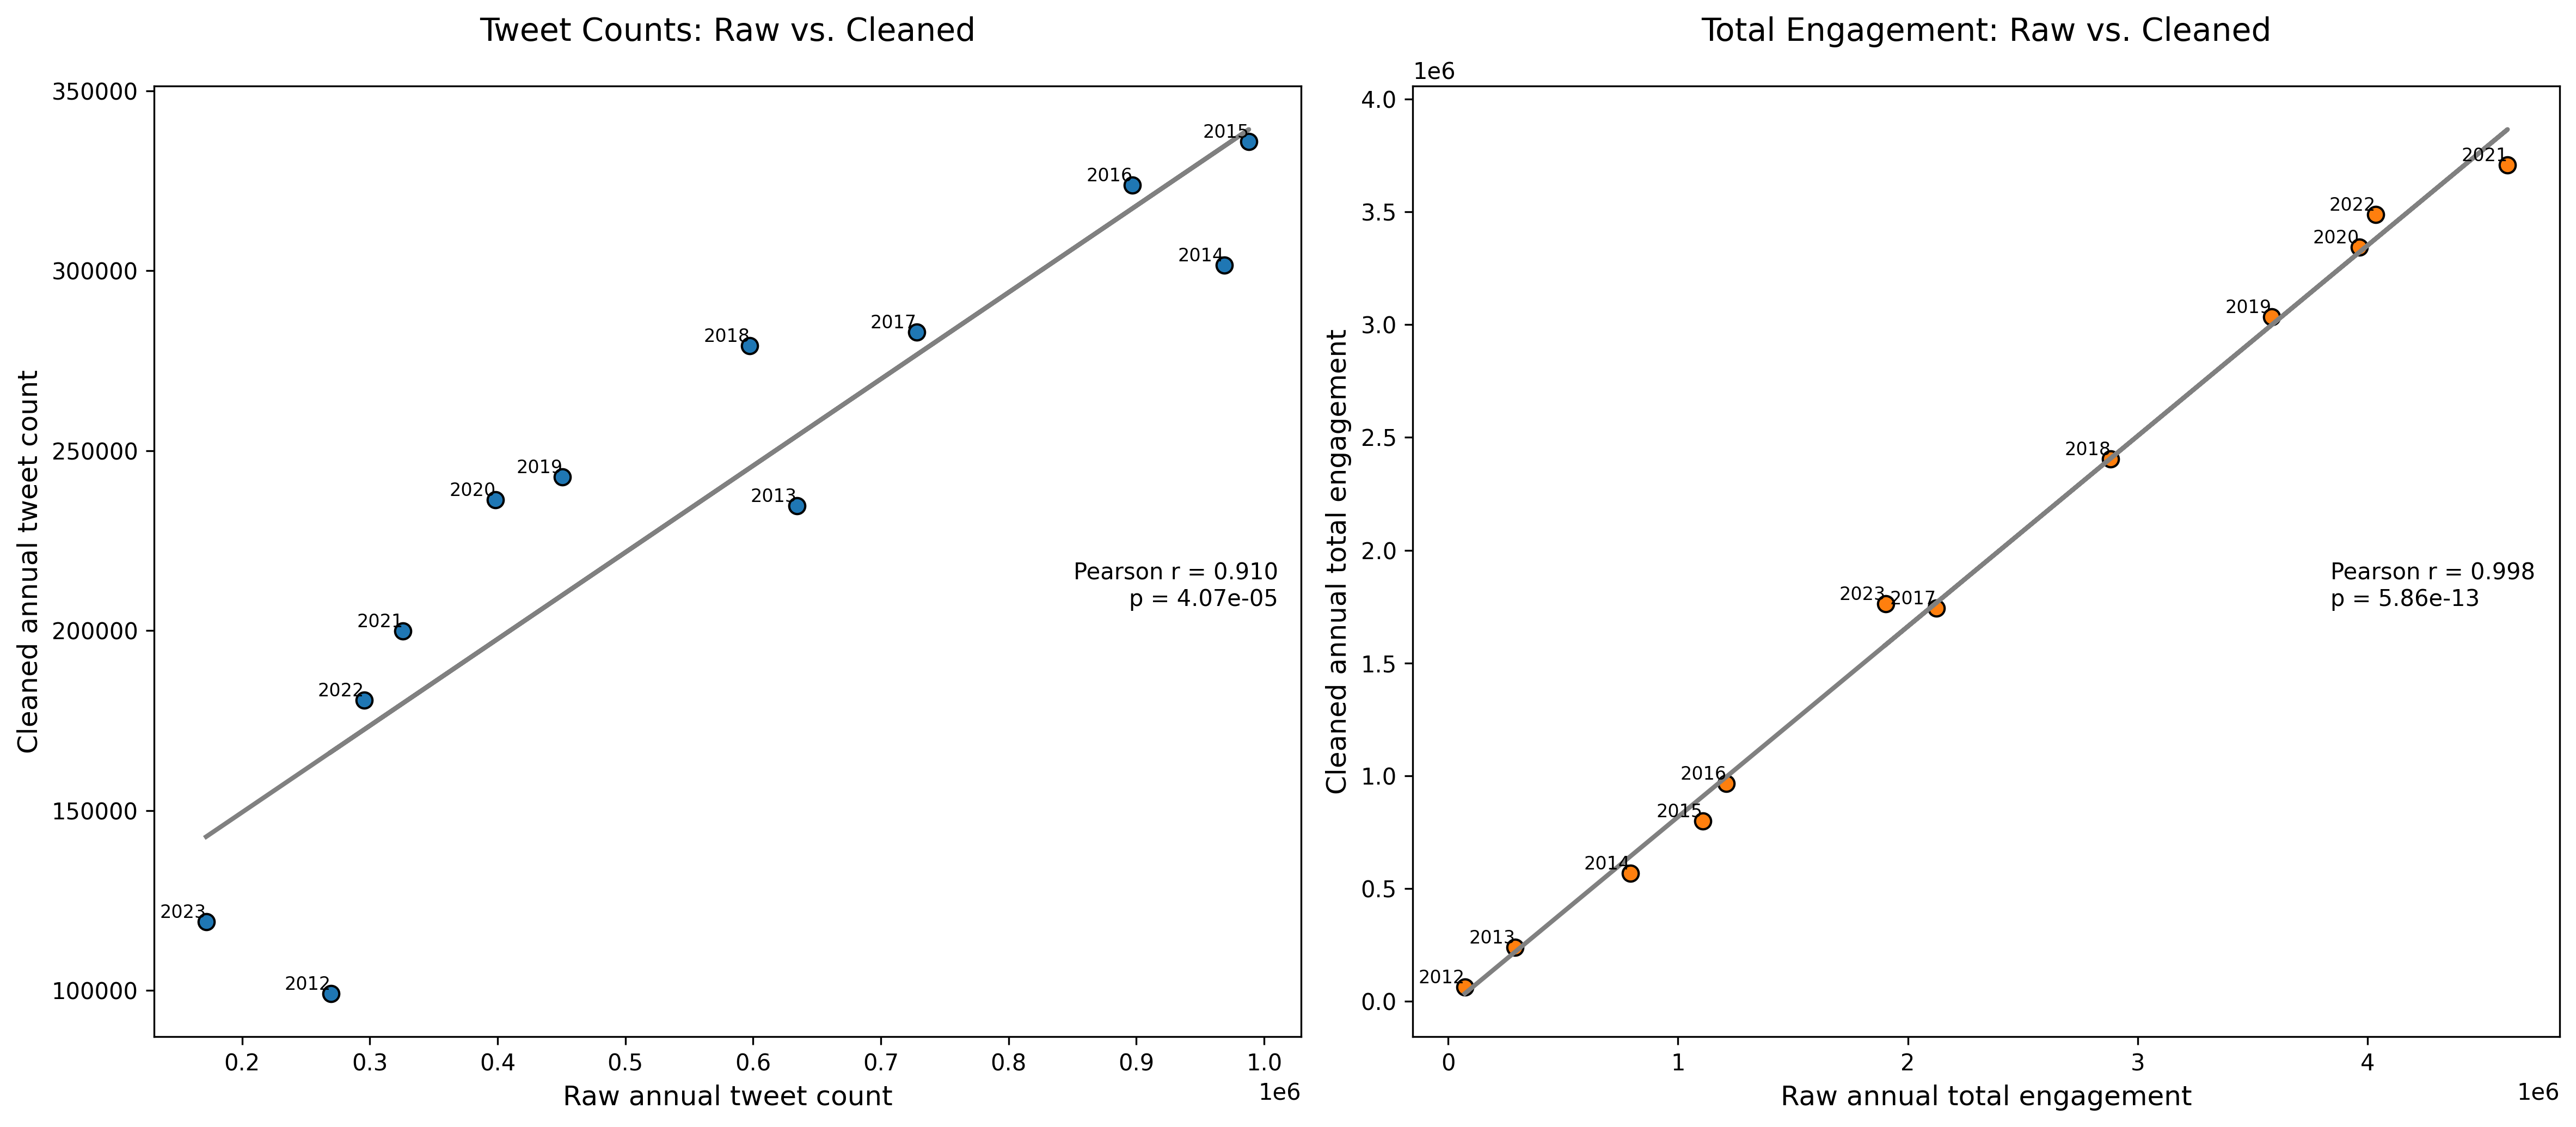

In [3]:
# pivot counts to wide
counts_wide = counts_df.pivot(index="Year", columns="Dataset", values="Tweet Count")
# pivot engagement to wide
eng_wide    = eng_df   .pivot(index="Year", columns="Dataset", values="Total Engagement")

# --- 1) EXTRACT X/Y VALUES FOR TWEET COUNTS SCATTER ---
years1 = counts_wide.index.astype(int)            # e.g. [2012, 2013, …]
x1 = counts_wide["Pre-cleaned"].astype(float)     # raw yearly tweet counts
y1 = counts_wide["Cleaned"].astype(float)         # cleaned yearly tweet counts

# Compute Pearson correlation for tweet counts
r_counts, p_counts = pearsonr(x1, y1)
print(f"Tweet Count correlation: Pearson r = {r_counts:.3f}, p = {p_counts:.3g}")

# --- 2) EXTRACT X/Y VALUES FOR ENGAGEMENT SCATTER ---
years2 = eng_wide.index.astype(int)               # e.g. [2012, 2013, …]
x2 = eng_wide["Pre-cleaned"].astype(float)        # raw yearly engagement
y2 = eng_wide["Cleaned"].astype(float)            # cleaned yearly engagement

# Compute Pearson correlation for engagement
r_eng, p_eng = pearsonr(x2, y2)
print(f"Engagement correlation: Pearson r = {r_eng:.3f}, p = {p_eng:.3g}")

# --- 3) MAKE A SINGLE FIGURE WITH TWO AXES SIDE BY SIDE ---
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 7), dpi=300)

# -------------------------------
# (A) LEFT PANEL: TWEET COUNTS
# -------------------------------
# Draw all points in a single color (e.g. “tab:blue”)
sc1 = ax1.scatter(
    x1,
    y1,
    color="tab:blue",
    s=50,
    edgecolor="black"
)

# Draw a solid best‐fit line
m1, b1 = np.polyfit(x1, y1, 1)
ax1.plot(
    x1,
    m1 * x1 + b1,
    color="gray",
    linewidth=2,
    linestyle="-"   # solid instead of dashed
)

# Label axes & title
ax1.set_xlabel("Raw annual tweet count", fontsize=12)
ax1.set_ylabel("Cleaned annual tweet count", fontsize=12)
ax1.set_title("Tweet Counts: Raw vs. Cleaned", fontsize=14, pad=20)

# Show the Pearson r / p‐value in the top‐right
ax1.text(
    0.98, 0.50,
    f"Pearson r = {r_counts:.3f}\np = {p_counts:.3g}",
    transform=ax1.transAxes,
    ha="right", va="top",
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none")
)

# Optionally, annotate each point with its year (uncomment if desired):
for xi, yi, yr in zip(x1, y1, years1):
    ax1.text(
        xi, yi, str(yr),
        fontsize=8,
        ha="right", va="bottom"
    )


# -------------------------------------
# (B) RIGHT PANEL: TOTAL ENGAGEMENT
# -------------------------------------
# Draw all points in a single color (e.g. “tab:orange”)
sc2 = ax2.scatter(
    x2,
    y2,
    color="tab:orange",
    s=50,
    edgecolor="black"
)

# Draw a solid best‐fit line
m2, b2 = np.polyfit(x2, y2, 1)
ax2.plot(
    x2,
    m2 * x2 + b2,
    color="gray",
    linewidth=2,
    linestyle="-"   # solid instead of dashed
)

ax2.set_xlabel("Raw annual total engagement", fontsize=12)
ax2.set_ylabel("Cleaned annual total engagement", fontsize=12)
ax2.set_title("Total Engagement: Raw vs. Cleaned", fontsize=14, pad=20)

# ax2.text(
#     0.98, 0.98,
#     f"Pearson r = {r_eng:.3f}\np = {p_eng:.3g}",
#     transform=ax2.transAxes,
#     ha="right", va="top",
#     fontsize=10,
#     bbox=dict(facecolor="white", alpha=0.8, edgecolor="none")
# )

ax2.text(
    0.80, 0.50,    # move it to 80% from the left, 90% up from the bottom
    f"Pearson r = {r_eng:.3f}\np = {p_eng:.3g}",
    transform=ax2.transAxes,
    ha="left",     # align the text-box’s left edge at x=0.80
    va="top",
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none")
)

# Optionally, annotate each engagement‐point with its year:
for xi, yi, yr in zip(x2, y2, years2):
    ax2.text(
        xi, yi, str(yr),
        fontsize=8,
        ha="right", va="bottom"
    )

# Layout adjustments
plt.tight_layout()
plt.savefig("./visualizations/counts_vs_engagement_scatter.png", 
            dpi=300, 
            bbox_inches="tight")
plt.show()


In [4]:
df_clean.shape

(2835759, 7)

In [6]:
from scipy.stats import linregress

# --- OLS for tweet counts ---------------------------------
slope1, intercept1, r_val1, p_val1, stderr1 = linregress(x1, y1)
residuals1 = y1 - (slope1 * x1 + intercept1)
print(f"Tweet-count OLS slope:      {slope1:.4f} ± {stderr1:.4f}")
print(f"Tweet-count OLS intercept:  {intercept1:.0f}")
print(f"Tweet-count residual σ:     {np.std(residuals1):.0f}")

# --- OLS for engagement -----------------------------------
slope2, intercept2, r_val2, p_val2, stderr2 = linregress(x2, y2)
residuals2 = y2 - (slope2 * x2 + intercept2)
print(f"Engagement OLS slope:       {slope2:.4f} ± {stderr2:.4f}")
print(f"Engagement OLS intercept:   {intercept2:.0f}")
print(f"Engagement residual σ:      {np.std(residuals2):.0f}")


Tweet-count OLS slope:      0.2409 ± 0.0348
Tweet-count OLS intercept:  101305
Tweet-count residual σ:     30074
Engagement OLS slope:       0.8443 ± 0.0184
Engagement OLS intercept:   -26779
Engagement residual σ:      87492


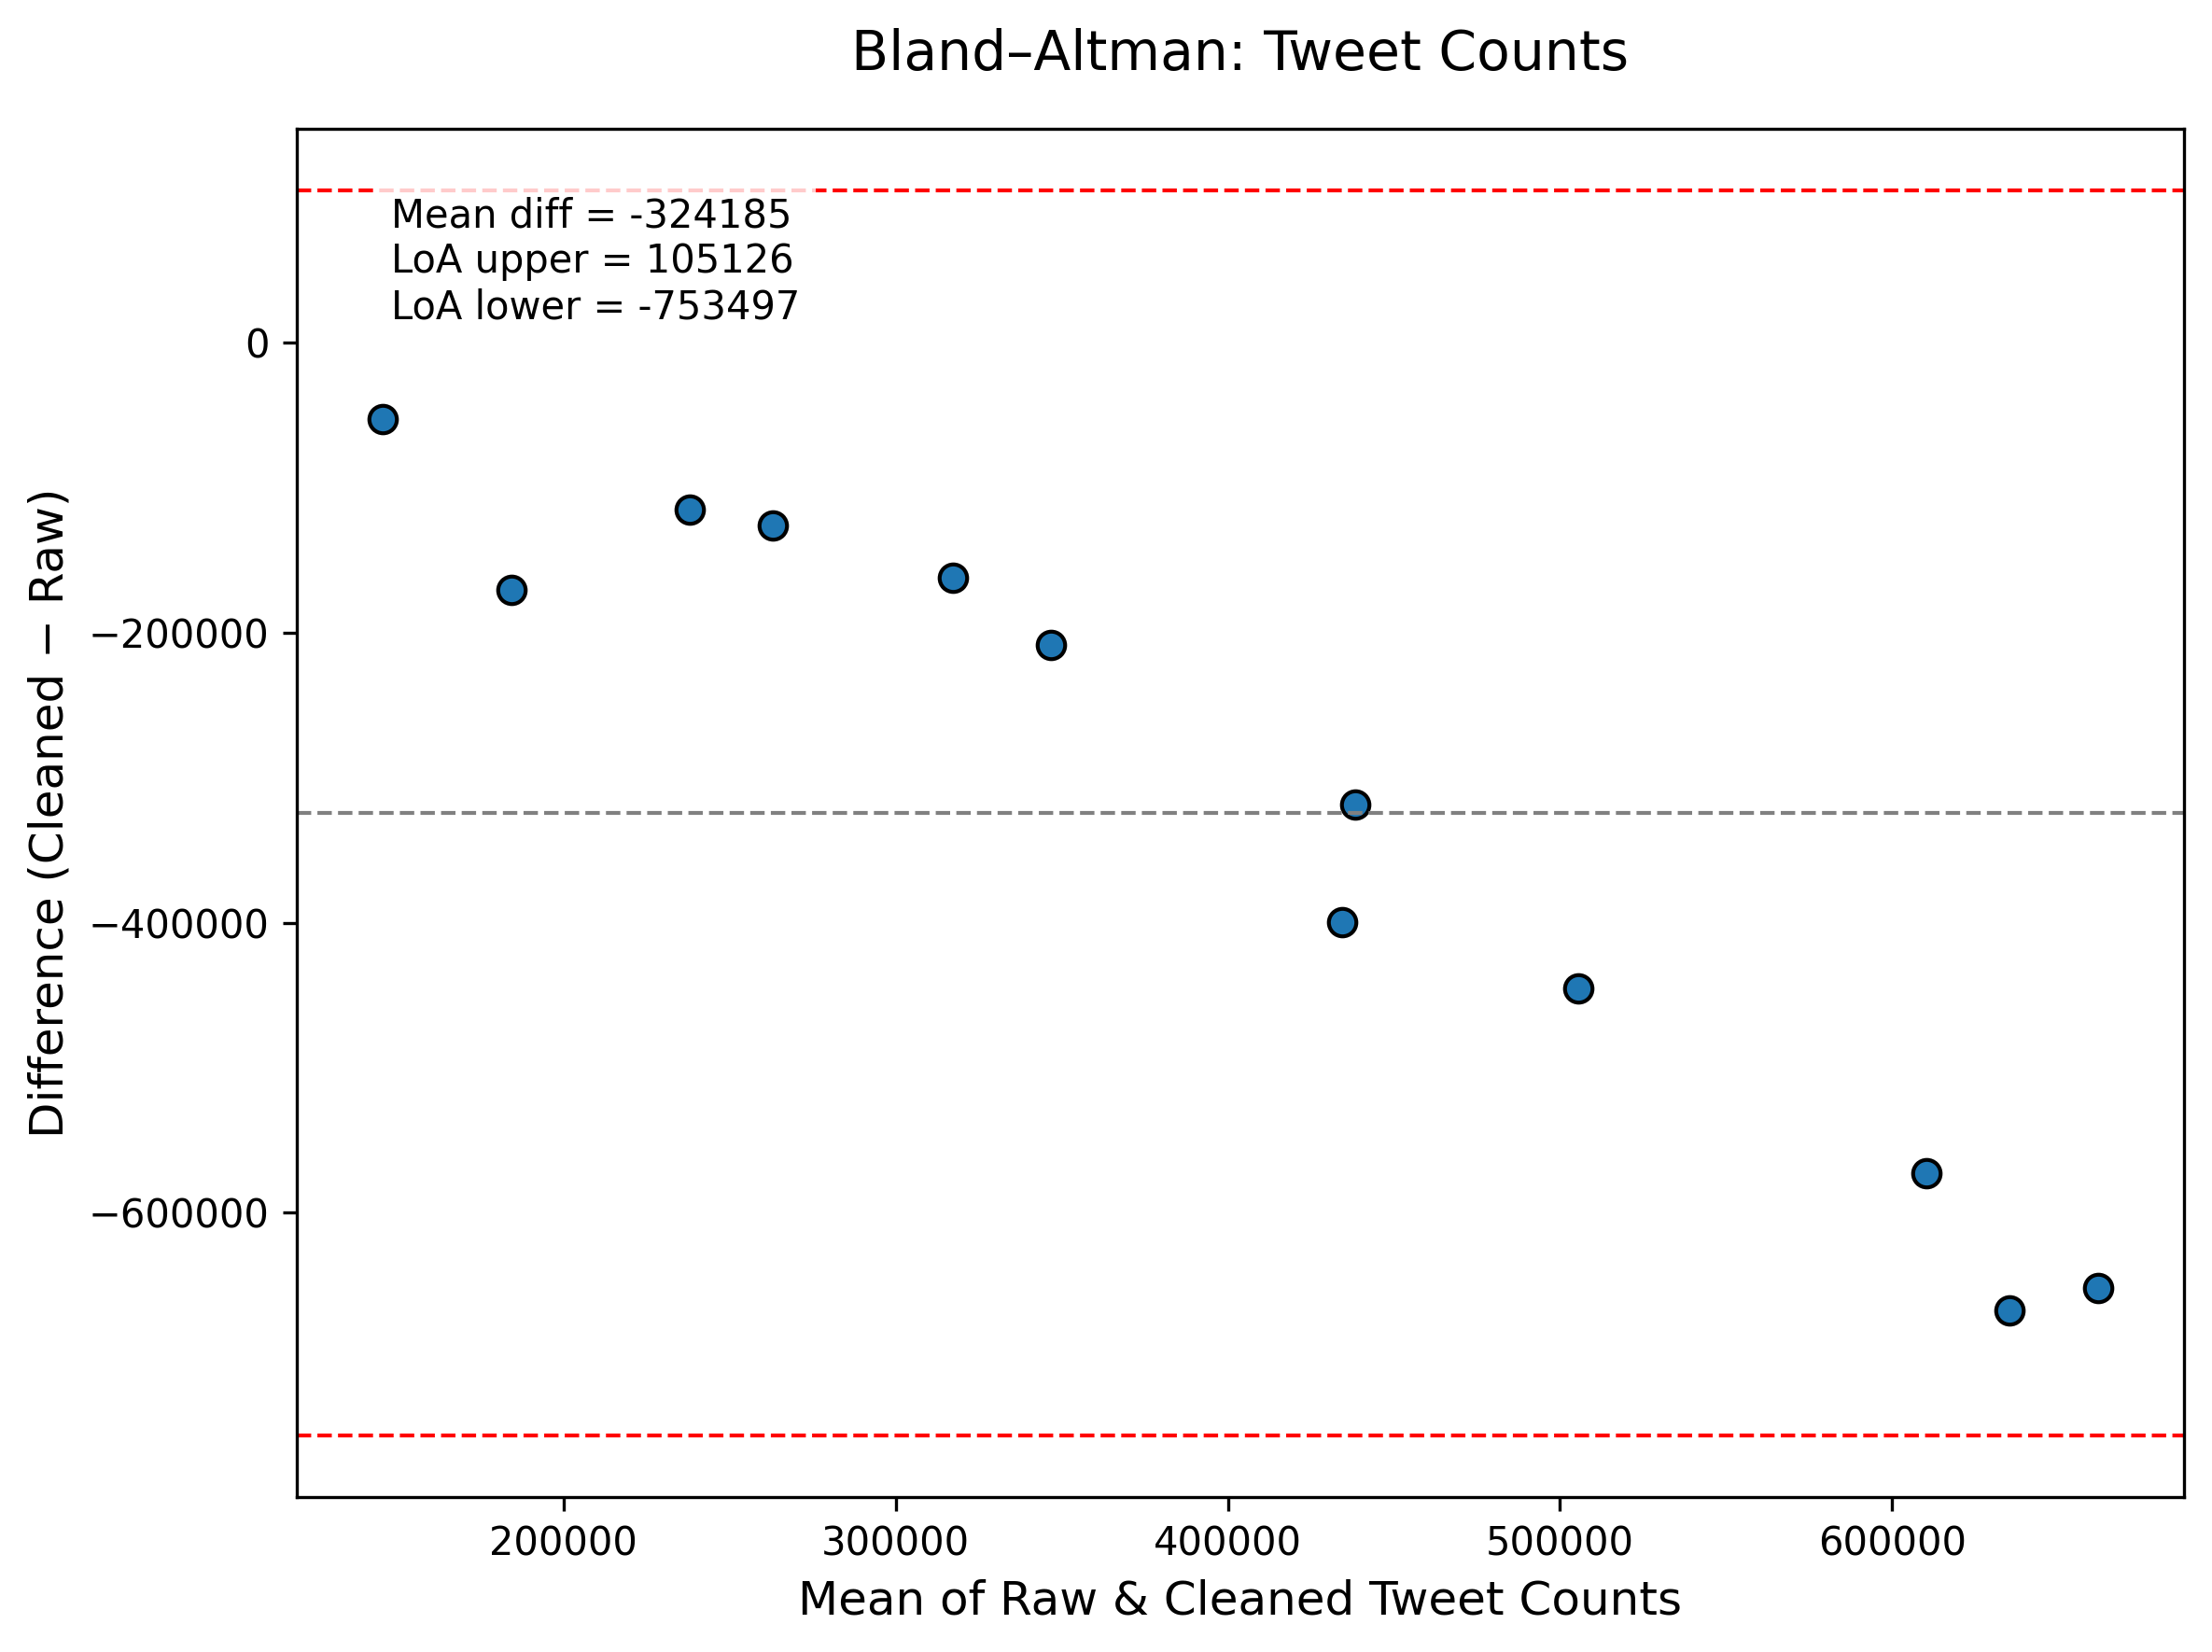

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ── Assume x1 and y1 are already defined as:
#    x1 = counts_wide["Pre-cleaned"].astype(float)
#    y1 = counts_wide["Cleaned"].astype(float)

# 1) Compute means and differences
mean_vals = (x1 + y1) / 2
diff_vals = y1 - x1

# 2) Compute the mean difference and its limits of agreement
mean_diff = np.mean(diff_vals)
sd_diff   = np.std(diff_vals, ddof=1)   # sample standard deviation

# 95% limits of agreement are (mean ± 1.96 * sd), assuming approx. normality
loa_upper = mean_diff + 1.96 * sd_diff
loa_lower = mean_diff - 1.96 * sd_diff

# 3) Make the plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

ax.scatter(mean_vals, diff_vals, color="tab:blue", s=50, edgecolor="black")
ax.axhline(mean_diff,   color="gray", linestyle="--", linewidth=1)
ax.axhline(loa_upper,   color="red",  linestyle="--", linewidth=1)
ax.axhline(loa_lower,   color="red",  linestyle="--", linewidth=1)

ax.set_xlabel("Mean of Raw & Cleaned Tweet Counts", fontsize=12)
ax.set_ylabel("Difference (Cleaned − Raw)", fontsize=12)
ax.set_title("Bland–Altman: Tweet Counts", fontsize=14, pad=15)

# Annotate the mean and LoA in the corner
textstr = (
    f"Mean diff = {mean_diff:.0f}\n"
    f"LoA upper = {loa_upper:.0f}\n"
    f"LoA lower = {loa_lower:.0f}"
)
ax.text(
    0.05, 0.95, textstr,
    transform=ax.transAxes,
    ha="left", va="top",
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none")
)

plt.tight_layout()
plt.show()
